# MNIST Training using PyTorch

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)

---

## Background

MNIST is a widely used dataset for handwritten digit classification. It consists of 70,000 labeled 28x28 pixel grayscale images of hand-written digits. The dataset is split into 60,000 training images and 10,000 test images. There are 10 classes (one for each of the 10 digits). This tutorial will show how to train and test an MNIST model on SageMaker using PyTorch.

For more information about using PyTorch in SageMaker, please visit [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers) and [sagemaker-python-sdk](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html) github repositories.

---

## Setup

_This notebook was created and tested on an ml.c5.4xlarge notebook instance._

Let's start by creating a SageMaker session and specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the `sagemaker.get_execution_role()` with a the appropriate full IAM role arn string(s).


In [1]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/DEMO-pytorch-mnist'

role = sagemaker.get_execution_role()

## Data
### Getting the data

Download the built-in MNIST dataset from the torchvision library. We also apply the following transformations -
- convert the input data into `torch.FloatTensor` and scale the pixel values to the range: `[0.0, 1.0]`.
- normalize the dataset using the mean and standard deviation of the pixel values from the dataset.

In [2]:
from torchvision import datasets, transforms

datasets.MNIST('data', download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

### Uploading the data to S3
We are going to use the `sagemaker.Session.upload_data` function to upload our datasets to an S3 location. The return value `inputs` identifies the location -- we will use later when we start the training job.


In [3]:
inputs = sagemaker_session.upload_data(path='data', bucket=bucket, key_prefix=prefix)
print('input spec (in this case, just an S3 path): {}'.format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-841336972682/sagemaker/DEMO-pytorch-mnist


## Train
### Training script
The `mnist.py` script provides all the code we need for training and hosting a SageMaker model (`model_fn` function to load a model).
The script is very similar to a training script you might run outside of SageMaker, but you can access useful properties about the training environment through various environment variables, such as:

* `SM_MODEL_DIR`: A string representing the path to the directory to write model artifacts to.
  These artifacts are uploaded to S3 for model hosting.
* `SM_NUM_GPUS`: The number of gpus available in the current container.
* `SM_CURRENT_HOST`: The name of the current container on the container network.
* `SM_HOSTS`: JSON encoded list containing all the hosts .

Supposing one input channel, 'training', was used in the call to the PyTorch estimator's `fit()` method, the following will be set, following the format `SM_CHANNEL_[channel_name]`:

* `SM_CHANNEL_TRAINING`: A string representing the path to the directory containing data in the 'training' channel.

For more information about training environment variables, please visit [SageMaker Containers](https://github.com/aws/sagemaker-containers).

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to `model_dir` so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an `argparse.ArgumentParser` instance.

Because the SageMaker imports the training script, you should put your training code in a main guard (``if __name__=='__main__':``) if you are using the same script to host your model as we do in this example, so that SageMaker does not inadvertently run your training code at the wrong point in execution.

Examine the script by running the following cell:

In [4]:
!pygmentize mnist.py

import argparse
import json
import logging
import os
import sys
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torch.utils.data.distributed
from torchvision import datasets, transforms

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


# Based on https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1

### Run training in SageMaker

The `PyTorch` class allows us to run our training function as a training job on SageMaker infrastructure. We need to configure it with our training script, an IAM role, the number of training instances, the training instance type, and hyperparameters. In this case we are going to run our training job on 2 ```ml.c4.xlarge``` instances. But this example can be run on one or multiple, cpu or gpu instances ([full list of available instances](https://aws.amazon.com/sagemaker/pricing/instance-types/)). The `hyperparameters` argument is a dict of values that will be passed to your training script -- you can see how to access these values in the `mnist.py` script above.

In [5]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point='mnist.py',
                    role=role,
                    framework_version='1.13.1',
                    py_version='py39',
                    instance_count=2,
                    instance_type='ml.c4.xlarge',
                    hyperparameters={
                        'epochs': 6,
                        'backend': 'gloo'
                    })

After we've constructed our `PyTorch` object, we can fit it using the data we uploaded to S3. SageMaker makes sure our data is available in the local filesystem, so our training script can simply read the data from disk.


In [6]:
estimator.fit({'training': inputs})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-03-23-08-39-46-350


2023-03-23 08:39:46 Starting - Starting the training job...
2023-03-23 08:40:13 Starting - Preparing the instances for training......
2023-03-23 08:41:07 Downloading - Downloading input data...
2023-03-23 08:41:32 Training - Downloading the training image........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-23 08:42:54,228 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-23 08:42:54,230 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-23 08:42:54,231 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-03-23 08:42:54,241 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-23 08:42:54,247 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-03-23 08:42:54,518 sagemaker-training-toolkit INFO     No GPUs detected


2023-03-23 08:42:53 Training - Training image download completed. Training in progress.Train Epoch: 1 [12800/30000 (43%)] Loss: 1.057153
INFO:__main__:Train Epoch: 1 [12800/30000 (43%)] Loss: 1.057153
Train Epoch: 1 [12800/30000 (43%)] Loss: 1.215783
INFO:__main__:Train Epoch: 1 [12800/30000 (43%)] Loss: 1.215783
Train Epoch: 1 [19200/30000 (64%)] Loss: 0.937700
INFO:__main__:Train Epoch: 1 [19200/30000 (64%)] Loss: 0.937700
Train Epoch: 1 [19200/30000 (64%)] Loss: 0.910202
INFO:__main__:Train Epoch: 1 [19200/30000 (64%)] Loss: 0.910202
Train Epoch: 1 [25600/30000 (85%)] Loss: 0.844424
INFO:__main__:Train Epoch: 1 [25600/30000 (85%)] Loss: 0.844424
Train Epoch: 1 [25600/30000 (85%)] Loss: 0.674952
INFO:__main__:Train Epoch: 1 [25600/30000 (85%)] Loss: 0.674952
/opt/conda/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/opt/conda/lib/python3.9/si


2023-03-23 08:44:59 Uploading - Uploading generated training model
2023-03-23 08:44:59 Completed - Training job completed
Training seconds: 466
Billable seconds: 466


## Host
### Create endpoint
After training, we use the `PyTorch` estimator object to build and deploy a `PyTorchPredictor`. This creates a Sagemaker Endpoint -- a hosted prediction service that we can use to perform inference.

As mentioned above we have implementation of `model_fn` in the `mnist.py` script that is required. We are going to use default implementations of `input_fn`, `predict_fn`, `output_fn` and `transform_fm` defined in [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers).

The arguments to the deploy function allow us to set the number and type of instances that will be used for the Endpoint. These do not need to be the same as the values we used for the training job. For example, you can train a model on a set of GPU-based instances, and then deploy the Endpoint to a fleet of CPU-based instances, but you need to make sure that you return or save your model as a cpu model similar to what we did in `mnist.py`. Here we will deploy the model to a single ```ml.m4.xlarge``` instance.

In [7]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: pytorch-training-2023-03-23-08-45-28-332
INFO:sagemaker:Creating endpoint-config with name pytorch-training-2023-03-23-08-45-28-332
INFO:sagemaker:Creating endpoint with name pytorch-training-2023-03-23-08-45-28-332


---------!

### Evaluate
We can now use this predictor to classify hand-written digits. We'll download the test data from the built-in dataset from torchvision and use a couple of images for testing the model.


Note that we apply the same transformations to the dataset and convert the tensor to numpy arrays.

In [8]:
from torch.utils.data import DataLoader

test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))]))


test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
test_dataset_array = next(iter(test_loader))[0].numpy()

Choose an image for passing to the predictor and obtaining a prediction. Change the value of `idx` to pick a different image for testing.

In [9]:
idx = 0
test_image = test_dataset_array[idx]

Visualize the image. 

INFO:matplotlib.font_manager:generated new fontManager


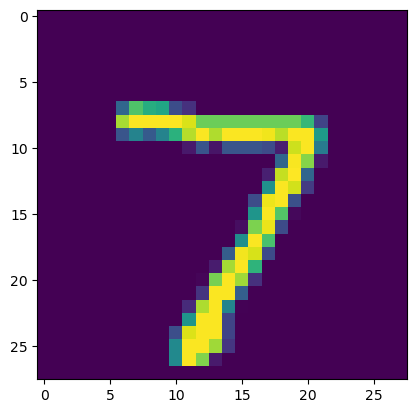

In [10]:
from matplotlib import pyplot as plt
plt.imshow(test_image.reshape(28, 28), interpolation='nearest')
plt.show()

Pass the chosen image to the predictor to obtain the prediction.

In [11]:
import numpy as np

response = predictor.predict(test_image)
prediction = response.argmax(axis=1)[0]
print(prediction)

7


### Cleanup

After you have finished with this example, remember to delete the prediction endpoint to release the instance(s) associated with it

In [12]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-training-2023-03-23-08-45-28-332
INFO:sagemaker:Deleting endpoint with name: pytorch-training-2023-03-23-08-45-28-332
